# Steered Variational AutoEncoder

**In this case the VAE is provided only 2 latent features - the other 2 are free**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from steered import SteeredVAE

### Generate data

In [6]:
size = 100000
d = 8

center = np.random.randint(1,d-1,size=(size,2))
height = np.random.randint(1,d//2-1,size=size)
width =  np.random.randint(1,d//2-1,size=size)

X = np.zeros((size,d,d),dtype=int)
y = np.zeros((size,4))

# paint rectangles
for i in range (len(X)):
    left = min(max(center[i,0]-width[i]//2,0),d-1)
    right = min(max(center[i,0]+width[i]//2,0),d-1)
    top = min(max(center[i,1]+height[i]//2,0),d-1)
    bottom = min(max(center[i,1]-height[i]//2,0),d-1)
    # fix single lines
    if abs(left-right) < 3:
        if (left>0):
            left-=1
        if (right<d-1):
            right+=1
    if abs(bottom-top) < 3:
        if (bottom>0):
            bottom-=1
        if (top<d-1):
            top+=1
    X[i,top,left:right+1] = 1
    X[i,bottom,left:right] = 1
    X[i,bottom:top,left] = 1
    X[i,bottom:top,right] = 1
    y[i,0] = abs(top-bottom)+1
    y[i,1] = abs(left-right)+1
    y[i,2] = (top+bottom)/2
    y[i,3] = (left+right)/2

# normalize y features
y_m = y.mean(axis=0)
y_s = y.std(axis=0)
y = (y-y_m)/y_s

# flatten
X = X.reshape(size,-1)

### Generate and train encoder

In [7]:
vae = SteeredVAE(64, [24,4],2)

**Note: only 2 features from y vector are provided**

In [9]:
vae.steer(X,y[:,:2],epochs=5)

Epoch: 1
Cost: -1007607.9011535645 1288.6028610765934
Epoch: 2
Cost: -1010576.4546508789 1288.2680977582932
Epoch: 3
Cost: -1011826.7154846191 1288.0482654869556
Epoch: 4
Cost: -1012166.920715332 1288.121046692133
Epoch: 5
Cost: -1015345.9353027344 1292.1860929727554


### Reconstruction

[-0.92644374 -0.93061229  0.31251721 -1.56911285]
[ 0.14923066 -1.77828     1.7603288   0.58240795]


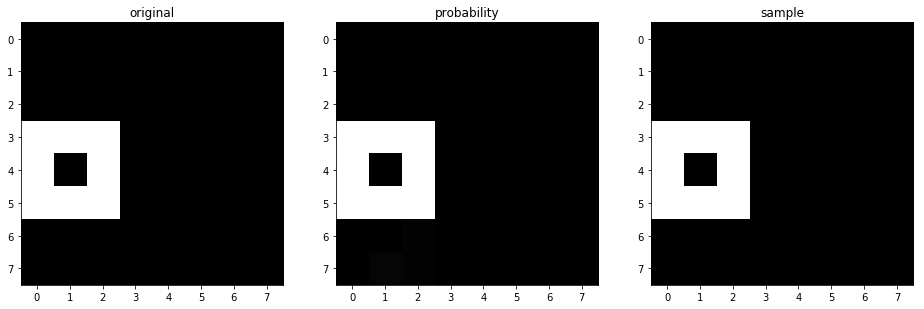

In [12]:
fig,axes = plt.subplots(ncols=3,figsize=(16,16))

i = np.random.choice(len(X))
aa,mm = vae.predict(X[i:i+3])
a = aa[0].reshape(d,d)
b = vae.predict(X[i],'sample')[0].reshape(d,d)

print(y[i])
print(mm[0])

axes[0].imshow(X[i].reshape(d,d),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('probability')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('sample')
plt.show()

### Observe latent space - steered features

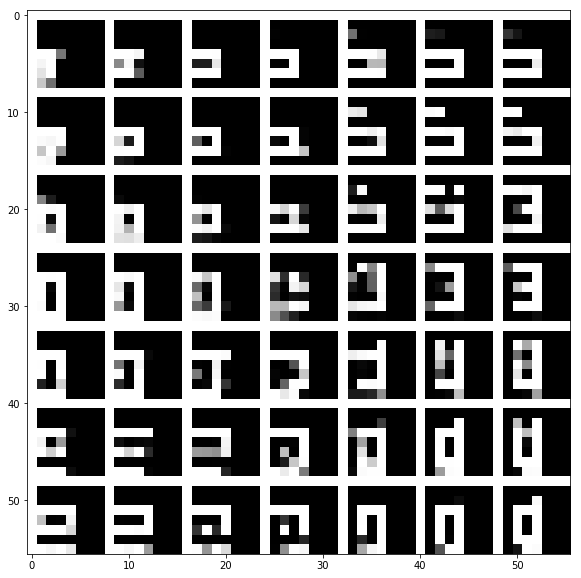

In [16]:
grid = 7
xs = np.linspace(-1, 2, grid)
ys = np.linspace(-1, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for xx in xs:
    for yy in ys:
        manual_Z.append([yy,xx,1,1])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for xx in range(grid):
    for yy in range(grid):
        idx = xx+yy*grid
        current = g[idx].reshape(d,d)
        latent[xx*d:(xx+1)*d,yy*d:(yy+1)*d] = current
        latent[xx*d,:] = 1
        latent[:,yy*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

More or less width and height, as trained

### Observe latent space - free features

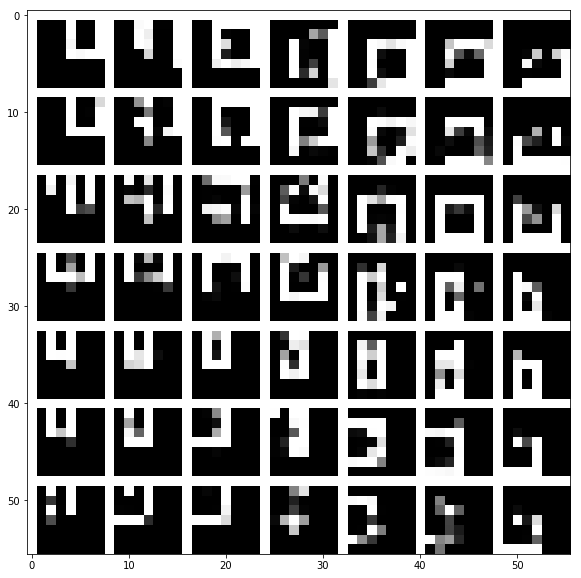

In [17]:
grid = 7
xs = np.linspace(-2, 2, grid)
ys = np.linspace(-2, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([1,1,y,x])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

Perhaps by chance, the other two features assume the position, but somewhat mixed